In [1]:
import os
import re
import time
import datetime
import operator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import word2vec
from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE
%matplotlib inline

### read data

In [2]:
tweet= pd.read_csv("data/Tweets.csv")
tweet[['tweet_id','text', 'airline_sentiment', 'airline_sentiment_confidence', 'airline']].head()

,tweet_id,text,airline_sentiment,airline_sentiment_confidence,airline
0,570306133677760513,@VirginAmerica What @dhepburn said.,neutral,1.0000,Virgin America
1,570301130888122368,@VirginAmerica plus you've added commercials t...,positive,0.3486,Virgin America
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837,Virgin America
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative,1.0000,Virgin America
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative,1.0000,Virgin America


In [3]:
tweet.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
tweet.shape

(14640, 15)

### data preprocessing

In [5]:
start_time = time.time()
#remove words which are starts with @ symbols
tweet['text'] = tweet['text'].map(lambda x:re.sub('@\w*','',str(x)))
#remove link starts with https
tweet['text'] = tweet['text'].map(lambda x:re.sub('http.*','',str(x)))
#remove special characters except [a-zA-Z]
tweet['text'] = tweet['text'].map(lambda x:re.sub('[^a-zA-Z]',' ',str(x)))
#lowercase
tweet['text'] = tweet['text'].map(lambda x:str(x).lower())
#Remove stopwords from comments
corpus = []
none=tweet['text'].map(lambda x:corpus.append(' '.join([word for word in str(x).strip().split() \
                                                        if not word in set(stopwords.words('english'))])))  
end_time = time.time()
#total time consume to filter data
print(end_time-start_time)

43.2703399658


In [6]:
corpus[:5]

['said',
 'plus added commercials experience tacky',
 'today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guests faces amp little recourse',
 'really big bad thing']

In [7]:
tweet['cleaned_text'] = pd.DataFrame(data=corpus,columns=['cleaned_text'])
x = tweet['cleaned_text']
tweet['tweet_length'] = tweet['cleaned_text'].apply(lambda x: len(x))
cleaned_word = words = ' '.join(x)
tweet['tweet_length'].head()

0     4
1    39
2    38
3    80
4    20
Name: tweet_length, dtype: int64

### check null

In [8]:
tweet[tweet.isnull().any(axis=1)].head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,cleaned_text,tweet_length
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,what said,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),said,4
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,plus you ve added commercials to the experien...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus added commercials experience tacky,39
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,i didn t today must mean i need to take an...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),today must mean need take another trip,38
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,it s really aggressive to blast obnoxious en...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...,80
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,and it s a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing,20


In [9]:
tweet.isnull().any(axis=0)

tweet_id                        False
airline_sentiment               False
airline_sentiment_confidence    False
negativereason                   True
negativereason_confidence        True
airline                         False
airline_sentiment_gold           True
name                            False
negativereason_gold              True
retweet_count                   False
text                            False
tweet_coord                      True
tweet_created                   False
tweet_location                   True
user_timezone                    True
cleaned_text                    False
tweet_length                    False
dtype: bool

In [9]:
np.sum(tweet.isnull().any(axis=1))

14638

In [10]:
tweet.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
cleaned_text                        0
tweet_length                        0
dtype: int64

In [11]:
print("Null Proportion: ")
(len(tweet)-tweet.count())/len(tweet)

Null Proportion: 


tweet_id                        0.000000
airline_sentiment               0.000000
airline_sentiment_confidence    0.000000
negativereason                  0.373087
negativereason_confidence       0.281284
airline                         0.000000
airline_sentiment_gold          0.997268
name                            0.000000
negativereason_gold             0.997814
retweet_count                   0.000000
text                            0.000000
tweet_coord                     0.930396
tweet_created                   0.000000
tweet_location                  0.323292
user_timezone                   0.329235
cleaned_text                    0.000000
tweet_length                    0.000000
dtype: float64

In [12]:
del tweet['airline_sentiment_gold']
del tweet['negativereason_gold']
del tweet['tweet_coord']

### text Frequency

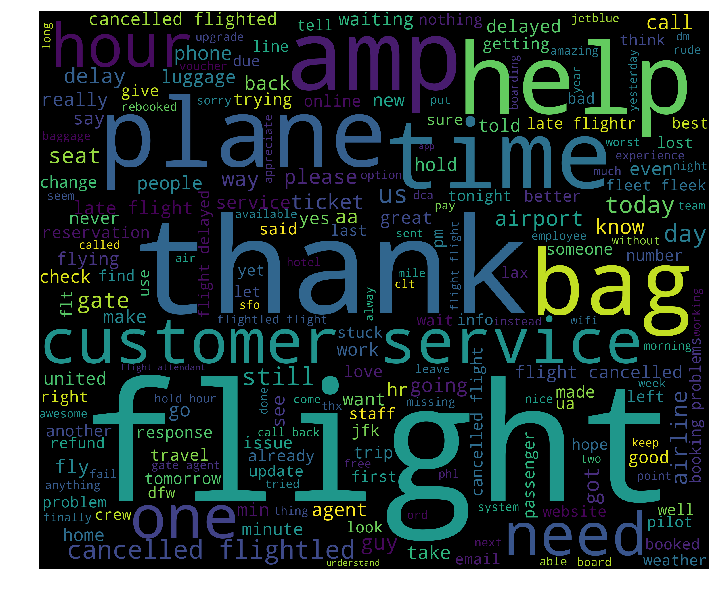

In [21]:
#visualization using wordcloud for all tweets
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [14]:
wordcount={}
for word in cleaned_word.split():
    if word not in wordcount:
        wordcount[word] = 1
    else:
        wordcount[word] += 1
wordcount_sort = sorted(wordcount.items(), reverse=True, key=lambda x: x[1])
                      
df_wc = pd.DataFrame(wordcount_sort, columns=['word', 'count'])
df_wc.head()

,word,count
0,flight,3954
1,get,1339
2,thanks,1080
3,cancelled,1065
4,service,966


Text(0,0.5,u'No. of Word')

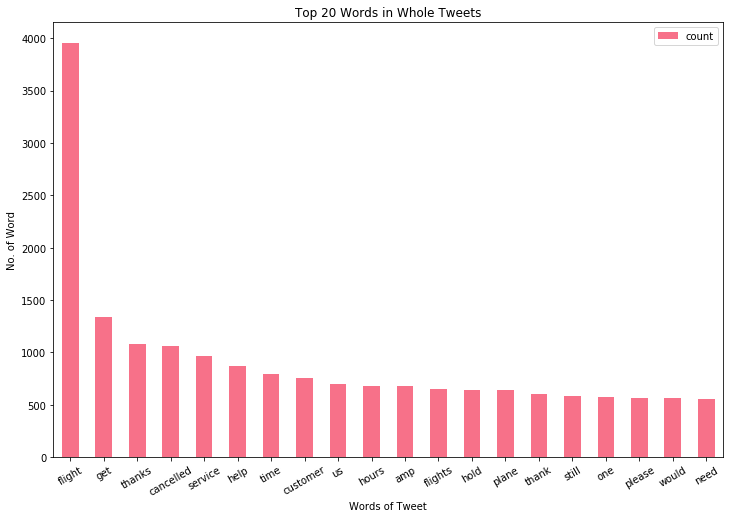

In [15]:
colors=sns.color_palette("husl", 10) 
df_wc[:20].plot(kind='bar', color=colors, 
                figsize=(12,8), fontsize=10, rot = 30, x = 'word', 
                title='Top 20 Words in Whole Tweets')
plt.xlabel('Words of Tweet', fontsize=10)
plt.ylabel('No. of Word', fontsize=10)

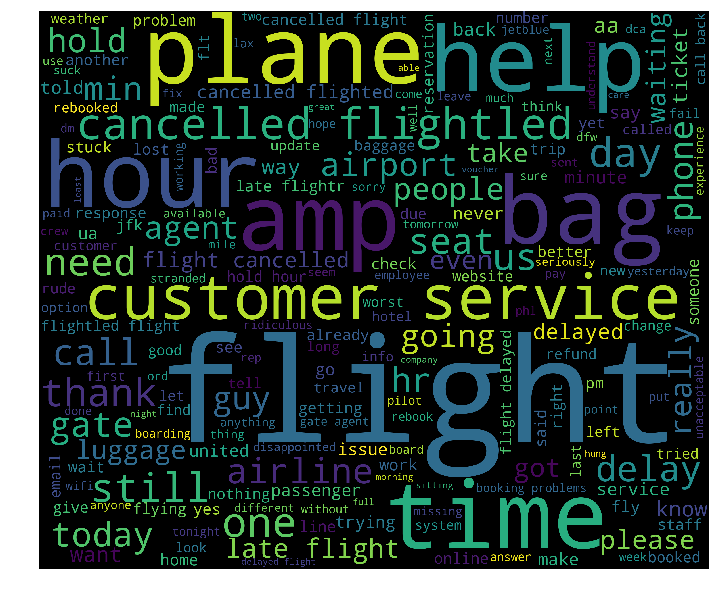

In [22]:
#visualization using wordcloud for the negative tweets
df_neg=tweet[tweet['airline_sentiment']=='negative']
words_neg = ' '.join(df_neg['cleaned_text'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500).generate(words_neg)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
wordcount_neg={}
for word in words_neg.split():
    if word not in wordcount_neg:
        wordcount_neg[word] = 1
    else:
        wordcount_neg[word] += 1
wordcount_sort_neg = sorted(wordcount_neg.items(), reverse=True, key=lambda x: x[1])
                      
df_wc_neg = pd.DataFrame(wordcount_sort_neg, columns=['word', 'count'])
df_wc_neg.head()

,word,count
0,flight,2957
1,get,987
2,cancelled,926
3,service,749
4,hours,658


Text(0,0.5,u'No. of Word')

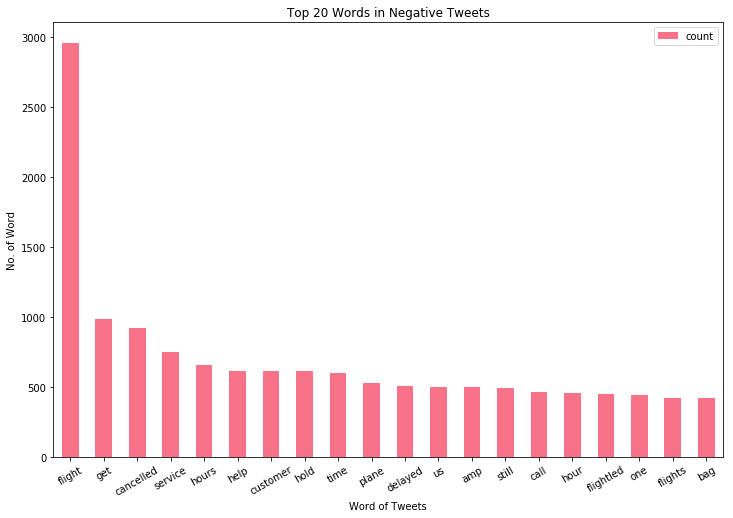

In [24]:
colors=sns.color_palette("husl", 10) 
df_wc_neg[:20].plot(kind='bar', color=colors,
                    figsize=(12,8), fontsize=10, rot = 30, x = 'word', 
                    title='Top 20 Words in Negative Tweets')
plt.xlabel('Word of Tweets', fontsize=10)
plt.ylabel('No. of Word', fontsize=10)

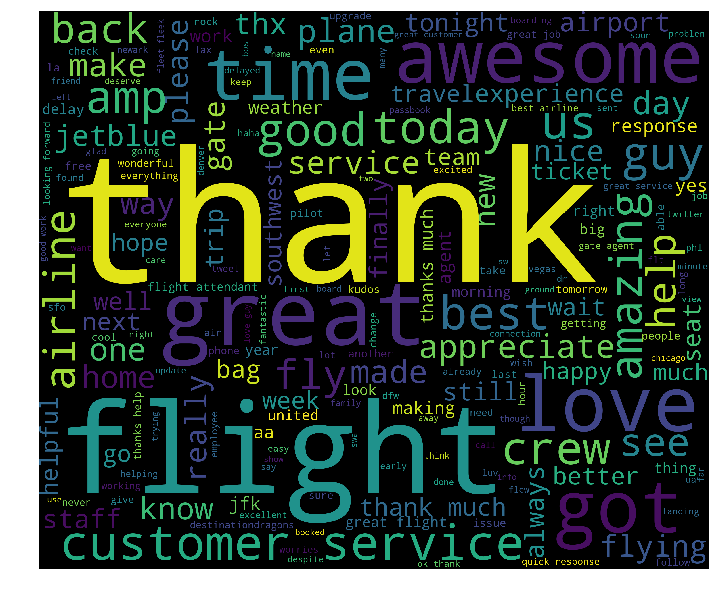

In [25]:
#visualization using wordcloud for the positive tweets
df_pos=tweet[tweet['airline_sentiment']=='positive']
words_pos = ' '.join(df_pos['cleaned_text'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500).generate(words_pos)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [26]:
wordcount_pos={}
for word in words_pos.split():
    if word not in wordcount_pos:
        wordcount_pos[word] = 1
    else:
        wordcount_pos[word] += 1
wordcount_sort_pos = sorted(wordcount_pos.items(), reverse=True, key=lambda x: x[1])
                      
df_wc_pos = pd.DataFrame(wordcount_sort_pos, columns=['word', 'count'])
df_wc_pos.head()

,word,count
0,thanks,610
1,thank,454
2,flight,381
3,great,234
4,service,162


Text(0,0.5,u'No. of Word')

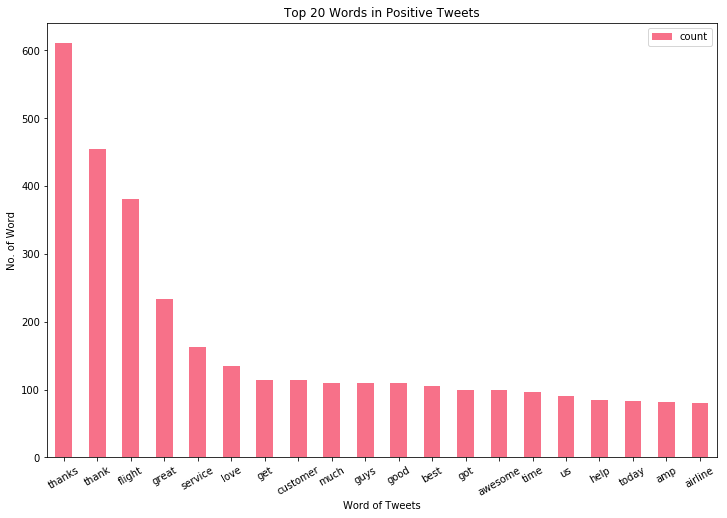

In [27]:
colors=sns.color_palette("husl", 10) 
df_wc_pos[:20].plot(kind='bar', color=colors,
                    figsize=(12,8), fontsize=10, rot = 30, x = 'word', 
                    title='Top 20 Words in Positive Tweets')
plt.xlabel('Word of Tweets', fontsize=10)
plt.ylabel('No. of Word', fontsize=10)

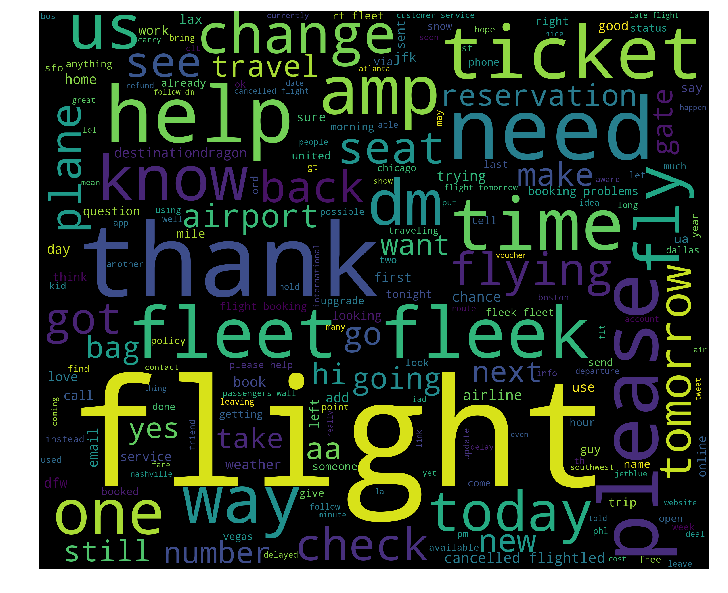

In [28]:
#visualization using wordcloud for the neutral tweets
df_neu=tweet[tweet['airline_sentiment']=='neutral']
words_neu = ' '.join(df_neu['cleaned_text'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500).generate(words_neu)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [29]:
wordcount_neu={}
for word in words_neu.split():
    if word not in wordcount_neu:
        wordcount_neu[word] = 1
    else:
        wordcount_neu[word] += 1
wordcount_sort_neu = sorted(wordcount_neu.items(), reverse=True, key=lambda x: x[1])
                      
df_wc_neu = pd.DataFrame(wordcount_sort_neu, columns=['word', 'count'])
df_wc_neu.head()

,word,count
0,flight,616
1,get,238
2,please,181
3,help,170
4,flights,168


Text(0,0.5,u'No. of Word')

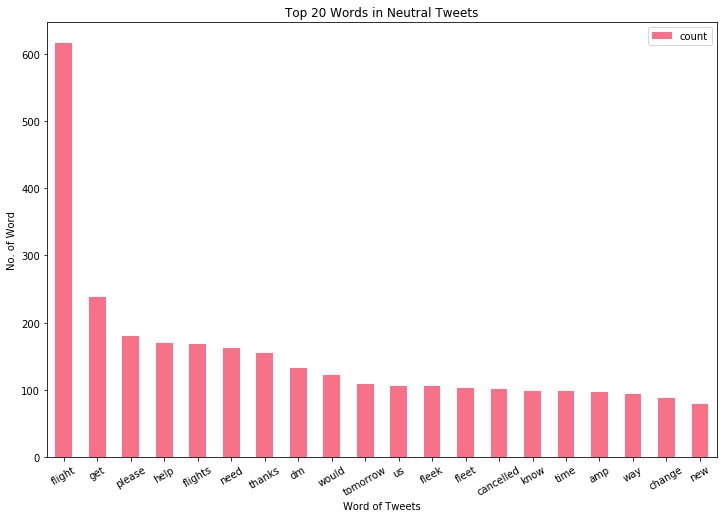

In [30]:
colors=sns.color_palette("husl", 10) 
df_wc_neu[:20].plot(kind='bar', color=colors,
                    figsize=(12,8), fontsize=10, rot = 30, x = 'word', 
                    title='Top 20 Words in Neutral Tweets')
plt.xlabel('Word of Tweets', fontsize=10)
plt.ylabel('No. of Word', fontsize=10)

### airline count

In [13]:
#counting the number of tweets each airlines has received 
tweet.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

Text(0,0.5,u'No. of Tweets')

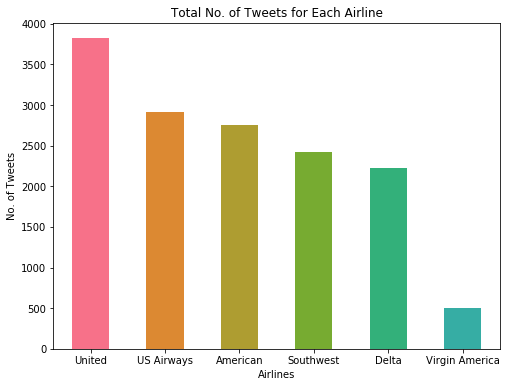

In [18]:
#Plotting the number of tweets each airlines has received
colors=sns.color_palette("husl", 10) 
pd.Series(tweet["airline"]).value_counts().plot(
    kind = "bar", color=colors, figsize=(8,6), fontsize=10, rot = 0, 
    title = "Total No. of Tweets for Each Airline")
plt.xlabel('Airlines', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

### sentiment count

In [15]:
#counting the number of each type of sentiments 
tweet.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0,0.5,u'No. of Tweets')

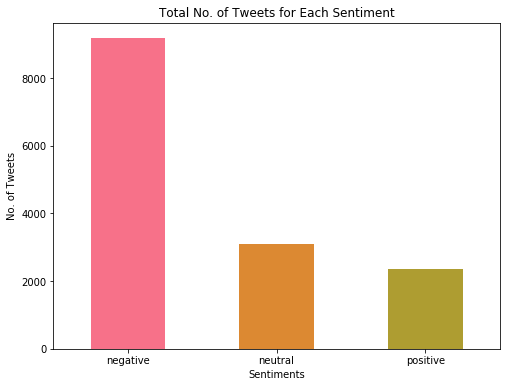

In [16]:
#Plotting the number of each type of sentiments 
colors=sns.color_palette("husl", 10)
pd.Series(tweet["airline_sentiment"]).value_counts().plot(
    kind = "bar",color=colors,figsize=(8,6),rot=0, 
    title = "Total No. of Tweets for Each Sentiment")
plt.xlabel('Sentiments', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

We can see that labels are unbalanced since there are many more negative tweets than neutral / positive tweets. We need to take this into account when evaluating models performance.

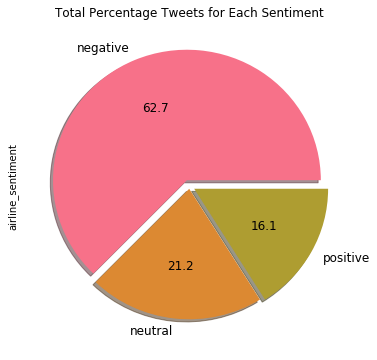

In [17]:
colors=sns.color_palette("husl", 10)
pd.Series(tweet["airline_sentiment"]).value_counts().plot(
    kind="pie",colors=colors,labels=["negative", "neutral", "positive"],
    explode=[0.05,0.02,0.04], shadow=True,autopct='%.1f', fontsize=12,figsize=(6, 6),
    title = "Total Percentage Tweets for Each Sentiment")

### timezone count

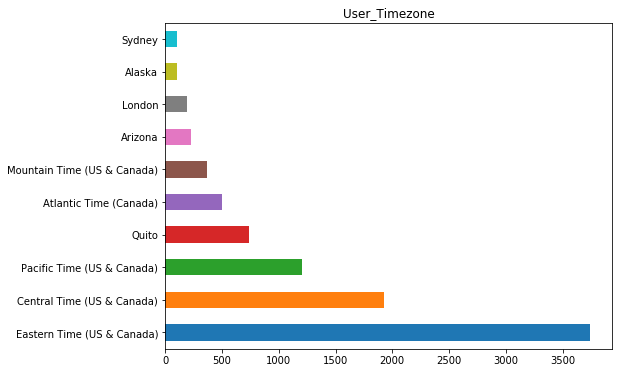

In [19]:
pd.Series(tweet["user_timezone"]).value_counts().head(10).plot(
    kind = "barh",figsize=(8,6),title = "User_Timezone")

### negativereason count

In [20]:
#counting the total number of negative reasons
tweet.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

Text(0,0.5,u'Negative Reasons')

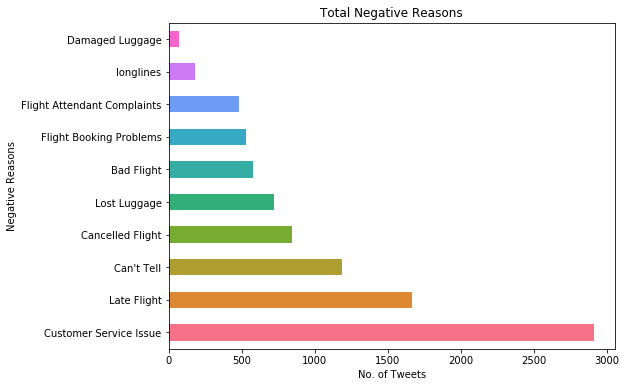

In [21]:
#Plotting all the negative reasons 
color=sns.color_palette("husl", 10)
pd.Series(tweet["negativereason"]).value_counts().plot(
    kind = "barh", color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('No. of Tweets', fontsize=10)
plt.ylabel('Negative Reasons', fontsize=10)

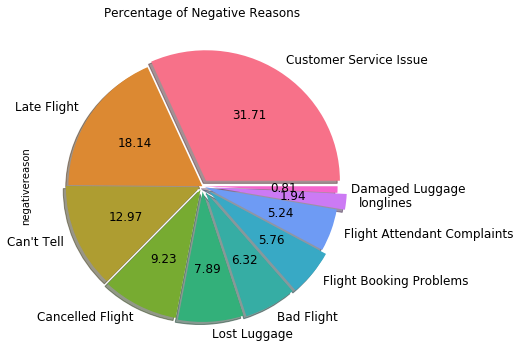

In [22]:
color=sns.color_palette("husl", 10)
pd.Series(tweet["negativereason"]).value_counts().plot(
    kind="pie",labels=["Customer Service Issue", "Late Flight", "Can't Tell","Cancelled Flight", "Lost Luggage", 
                       "Bad Flight", "Flight Booking Problems", "Flight Attendant Complaints", "longlines",
                      "Damaged Luggage"],
    colors=color,autopct='%.2f',explode=[0.05,0,0.02,0.03,0.04,0.05,0.06,0.02,0.08,0.01],shadow=True,
    fontsize=12,figsize=(6, 6),title="Percentage of Negative Reasons")

### sentiment across tweet_length

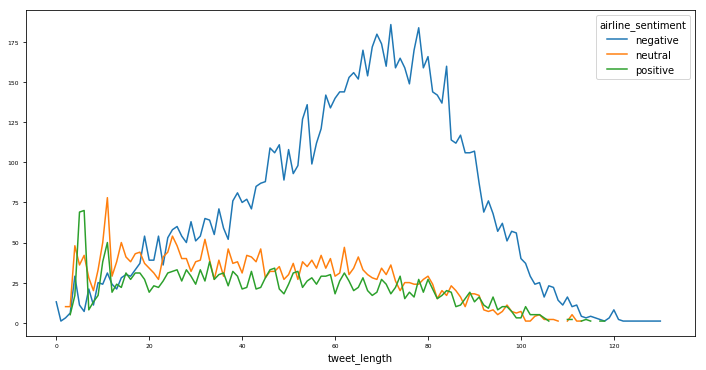

In [23]:
tweet['tweet_length'] = tweet['cleaned_text'].apply(len)
tweet.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(
    kind='line', figsize=(12, 6), fontsize=6, stacked=False)

### negativereason cross airline

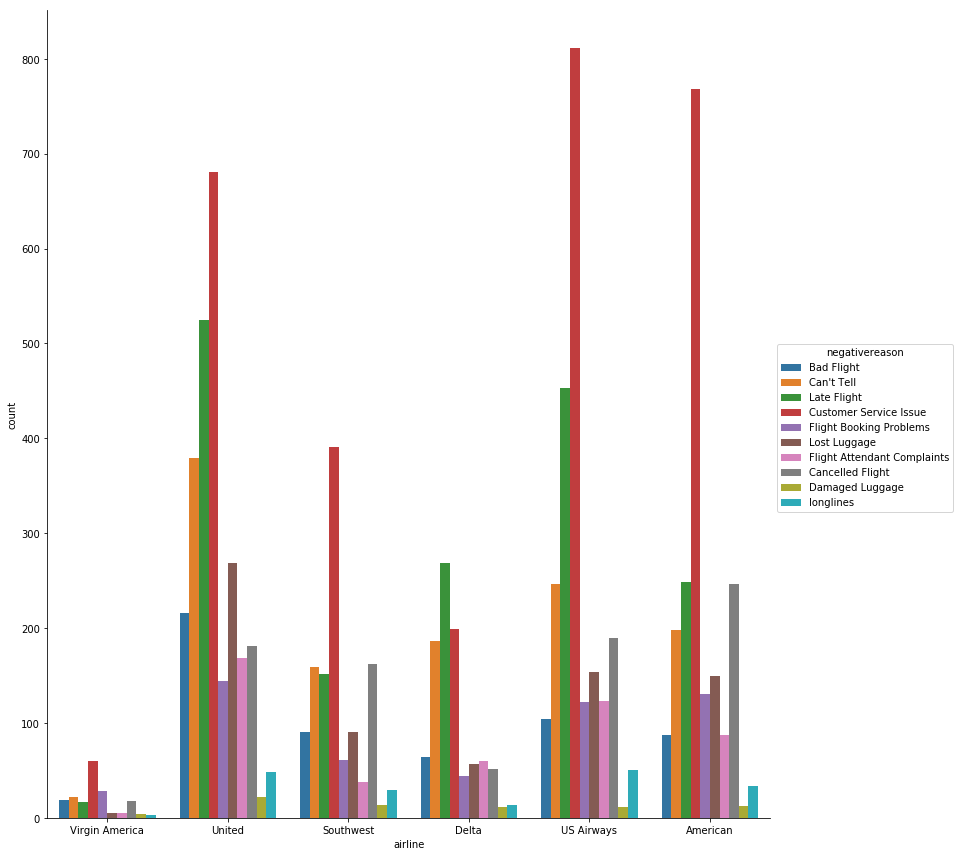

In [24]:
sns.factorplot(x = 'airline',
               data = tweet,kind = 'count',
               hue='negativereason',size=12,aspect=.9)
plt.show()

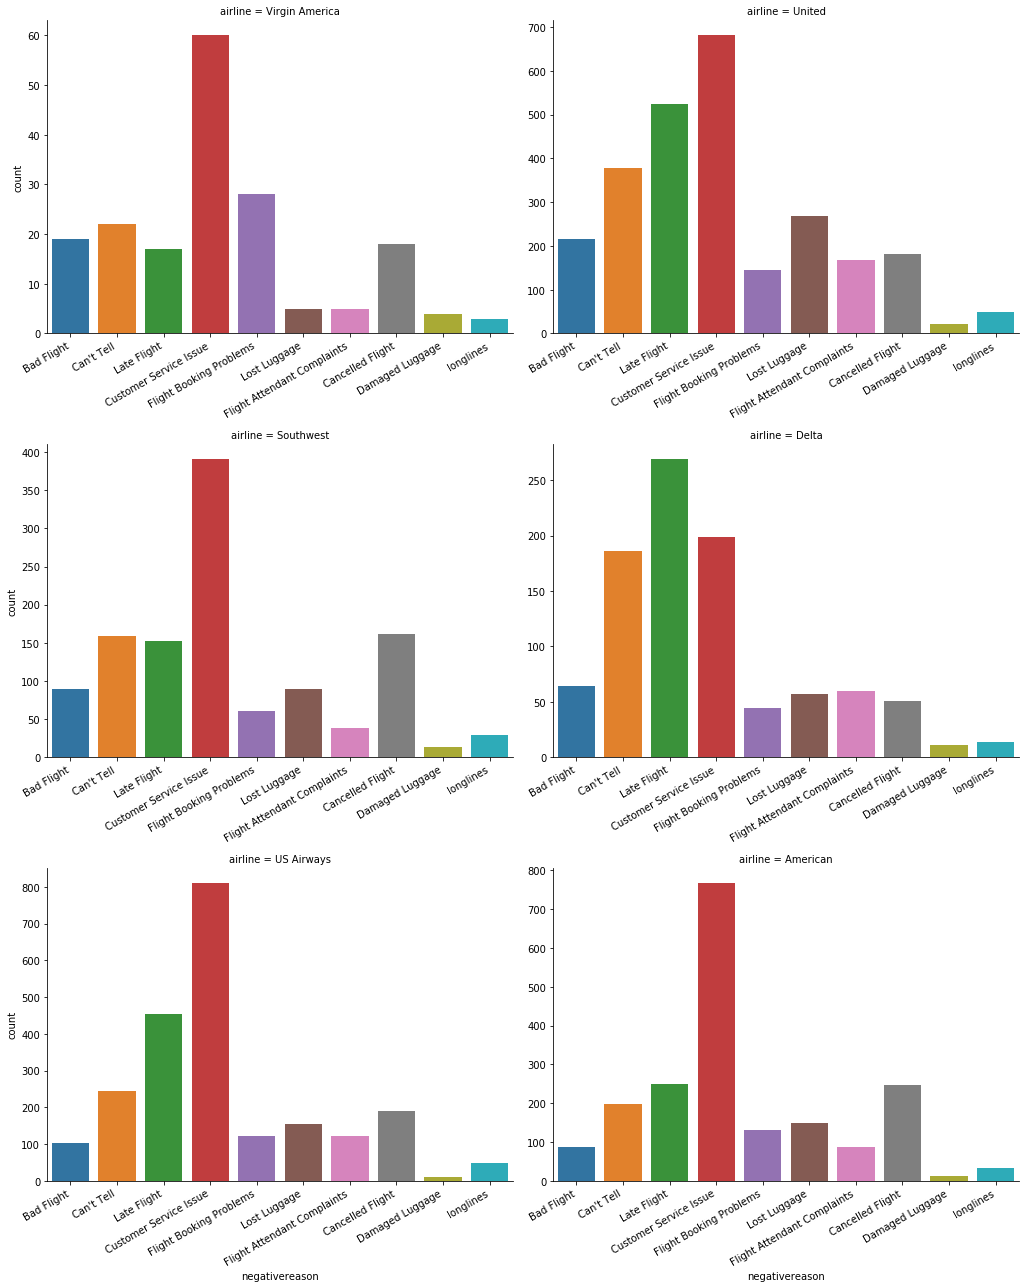

In [25]:
g = sns.factorplot(x = 'negativereason',
               data=tweet,kind='count',col='airline',
               size=6,aspect=1.2,col_wrap=2,sharex=False,sharey=False)

for i, ax in enumerate(g.fig.axes):   ## getting all axes of the fig object
     ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha="right")
plt.tight_layout()
plt.show()

### sentiment cross airline

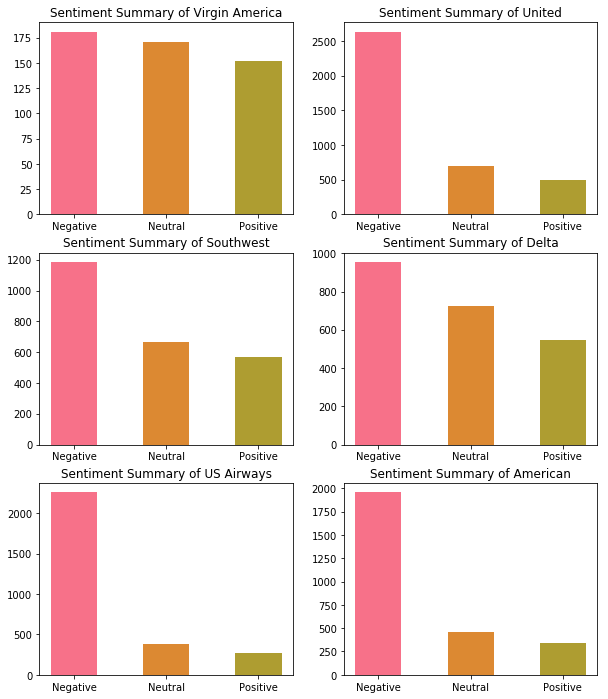

In [26]:
def plot_sub_sentiment(Airline):
    pdf = tweet[tweet['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("husl", 10)
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment Summary of' + " " + Airline)

airline_name = tweet['airline'].unique()
plt.figure(1,figsize=(10,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])

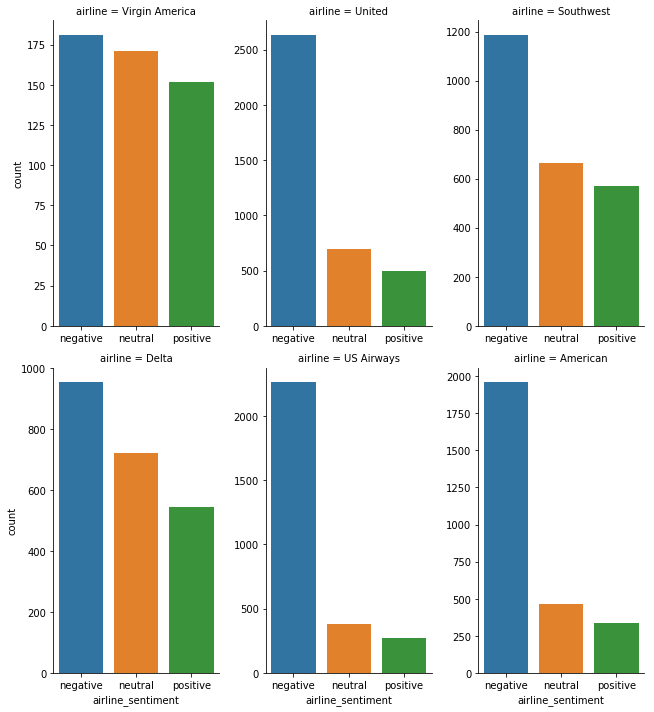

In [27]:
sns.factorplot(x = 'airline_sentiment',data=tweet,
               order = ['negative','neutral','positive'],
               kind = 'count',col_wrap=3,col='airline',
               size=5,aspect=0.6,sharex=False,sharey=False)
plt.show()

In [28]:
air_senti=pd.crosstab(tweet.airline, tweet.airline_sentiment)
air_senti

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


In [29]:
percent=air_senti.apply(lambda a: a / a.sum() * 100, axis=1)
percent

airline_sentiment,negative,neutral,positive
airline,,,
American,71.040232,16.781443,12.178325
Delta,42.979298,32.538254,24.482448
Southwest,49.008264,27.438017,23.553719
US Airways,77.686234,13.079300,9.234466
United,68.890633,18.236525,12.872841
Virgin America,35.912698,33.928571,30.158730


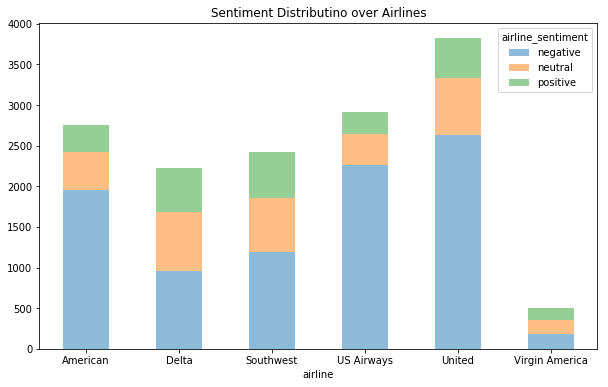

In [47]:
pd.crosstab(index = tweet["airline"],columns = tweet["airline_sentiment"]).plot(
    kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment Distributino over Airlines")

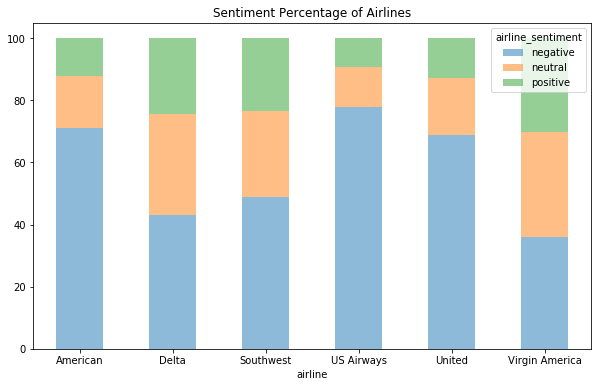

In [48]:
percent.plot(kind='bar',figsize=(10, 6),alpha=0.5,
             rot=0,stacked=True,title="Sentiment Percentage of Airlines")

### tweets created time

In [32]:
tweet['tweet_created'] = pd.to_datetime(tweet['tweet_created'])
tweet["tweet_created_date"] = tweet["tweet_created"].dt.date
tweet['tweet_created_time'] = tweet.tweet_created.dt.time
tweet['tweet_created_hour'] = tweet.tweet_created.dt.hour
tweet["tweet_created_date"].value_counts(ascending=True)

2015-02-17     953
2015-02-19    1298
2015-02-18    1416
2015-02-21    1418
2015-02-20    1512
2015-02-24    2136
2015-02-22    2392
2015-02-23    3515
Name: tweet_created_date, dtype: int64

### sentiment across created_date

In [33]:
date_senti = pd.crosstab(tweet.tweet_created_date, tweet.airline_sentiment)
date_senti

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,552,220,181
2015-02-18,827,304,285
2015-02-19,666,346,286
2015-02-20,849,383,280
2015-02-21,901,272,245
2015-02-22,1744,367,281
2015-02-23,2346,711,458
2015-02-24,1293,496,347


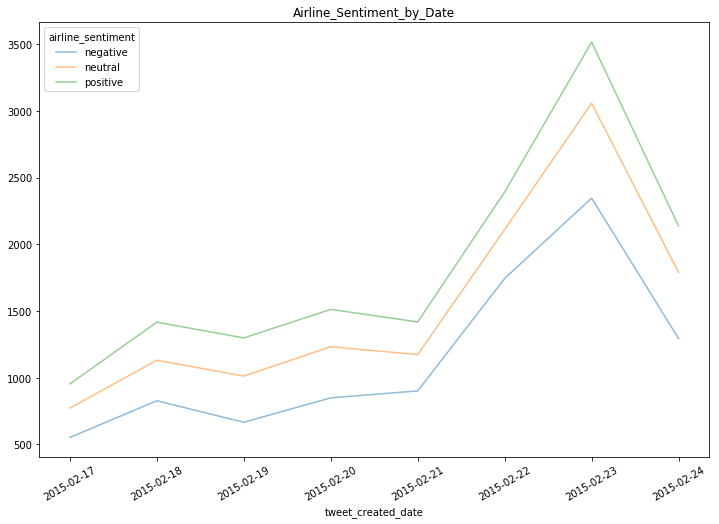

In [34]:
pd.crosstab(index = tweet["tweet_created_date"],columns = tweet["airline_sentiment"]).plot(
    kind='line',figsize=(12, 8),alpha=0.5,rot=30,stacked=True,
    title="Airline_Sentiment_by_Date")

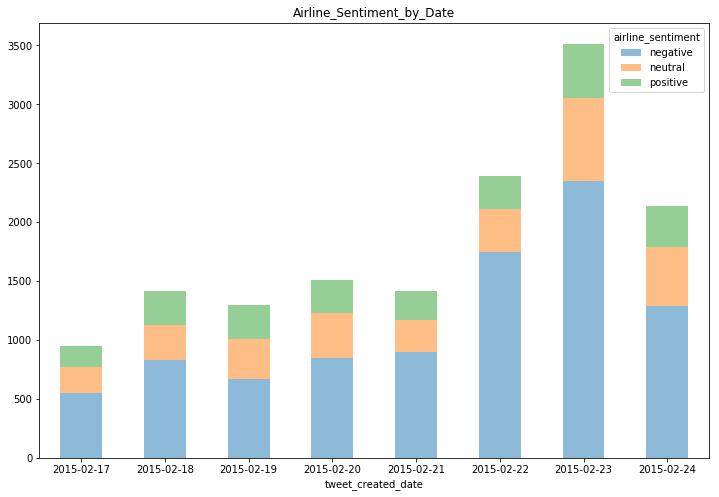

In [35]:
pd.crosstab(index = tweet["tweet_created_date"],columns = tweet["airline_sentiment"]).plot(
    kind='bar',figsize=(12, 8),alpha=0.5,rot=0,stacked=True,
    title="Airline_Sentiment_by_Date")

In [36]:
percent2 = date_senti.apply(lambda a: a / a.sum() * 100, axis=1)
percent2

airline_sentiment,negative,neutral,positive
tweet_created_date,,,
2015-02-17,57.922350,23.084995,18.992655
2015-02-18,58.403955,21.468927,20.127119
2015-02-19,51.309707,26.656394,22.033898
2015-02-20,56.150794,25.330688,18.518519
2015-02-21,63.540197,19.181946,17.277856
2015-02-22,72.909699,15.342809,11.747492
2015-02-23,66.742532,20.227596,13.029872
2015-02-24,60.533708,23.220974,16.245318


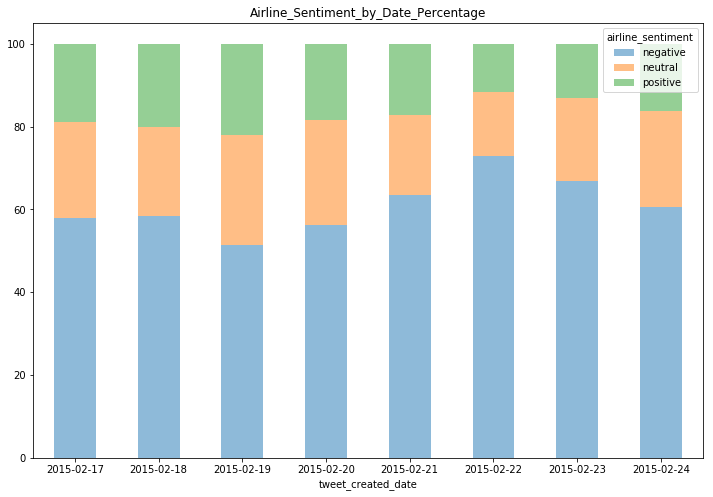

In [37]:
percent2.plot(kind='bar',figsize=(12, 8),alpha=0.5,rot=0,stacked=True,
             title="Airline_Sentiment_by_Date_Percentage")

### sentiment across date, airline

In [38]:
df = tweet.groupby(['tweet_created_date','airline'])
df = df.airline_sentiment.value_counts()
df.unstack()

airline_sentiment                  negative  neutral  positive
tweet_created_date airline                                    
2015-02-17         Delta               51.0     63.0      47.0
                   Southwest          162.0     69.0      56.0
                   US Airways         156.0     22.0      33.0
                   United             173.0     50.0      29.0
                   Virgin America      10.0     16.0      16.0
2015-02-18         Delta              127.0     84.0      78.0
                   Southwest          143.0     96.0      90.0
                   US Airways         259.0     29.0      44.0
                   United             281.0     74.0      53.0
                   Virgin America      17.0     21.0      20.0
2015-02-19         American             1.0      NaN       1.0
                   Delta              127.0     68.0      74.0
                   Southwest          103.0    102.0      86.0
                   US Airways         189.0     58.0      34.0
                   United             224.0     97.0      71.0
                   Virgin America      22.0     21.0      20.0
2015-02-20         American             1.0      NaN       NaN
                   Delta              108.0     97.0      78.0
                   Southwest          139.0     98.0      73.0
                   US Airways         234.0     50.0      34.0
                   United             347.0    104.0      78.0
                   Virgin America      20.0     34.0      17.0
2015-02-21         American             1.0      NaN       NaN
                   Delta               91.0     78.0      55.0
                   Southwest          219.0     77.0      64.0
                   US Airways         224.0     31.0      26.0
                   United             333.0     72.0      72.0
                   Virgin America      33.0     14.0      28.0
2015-02-22         American           316.0     46.0      42.0
                   Delta              221.0     82.0      83.0
                   Southwest          143.0     52.0      53.0
                   US Airways         536.0     58.0      28.0
                   United             494.0    109.0      63.0
                   Virgin America      34.0     20.0      12.0
2015-02-23         American          1071.0    214.0     144.0
                   Delta              160.0    181.0      83.0
                   Southwest          151.0    107.0      94.0
                   US Airways         431.0     76.0      46.0
                   United             503.0    103.0      71.0
                   Virgin America      30.0     30.0      20.0
2015-02-24         American           570.0    203.0     149.0
                   Delta               70.0     70.0      46.0
                   Southwest          126.0     63.0      54.0
                   US Airways         234.0     57.0      24.0
                   United             278.0     88.0      55.0
                   Virgin America      15.0     15.0      19.0

Text(0,0.5,u'Reviews')

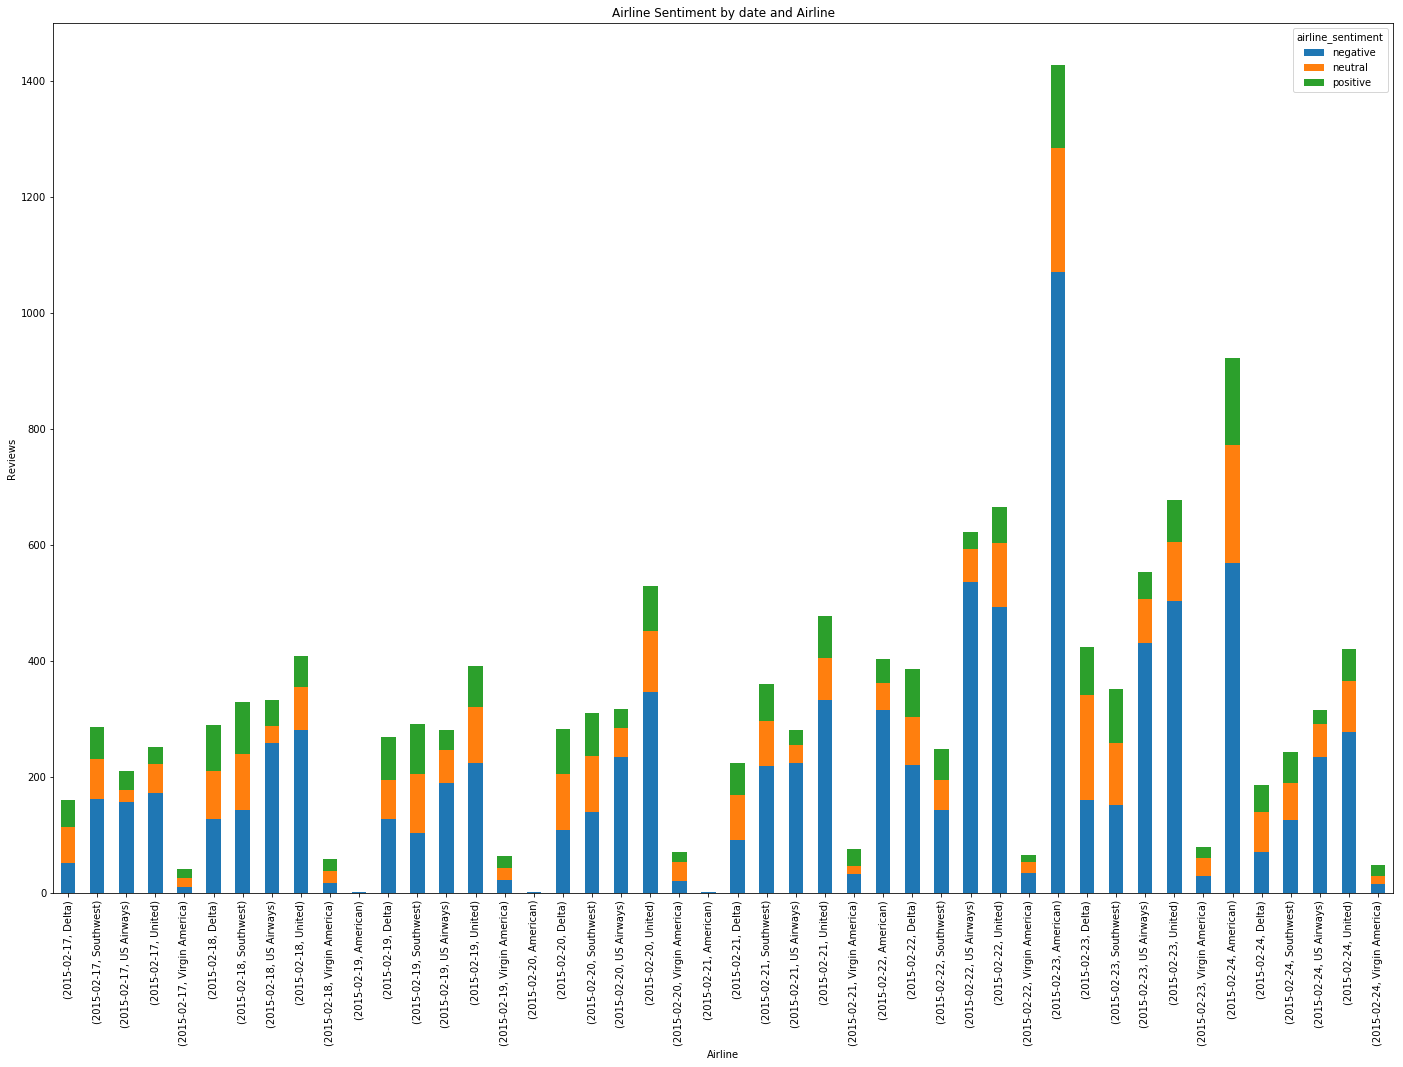

In [39]:
my_plot = df.unstack().plot(kind='bar',stacked=True,figsize=(24, 16),rot=90,
                            title="Airline Sentiment by date and Airline")
my_plot.set_xlabel("Airline")
my_plot.set_ylabel("Reviews")

### negativereason across created_hour

In [40]:
pf_neg = tweet.groupby(['tweet_created_hour']).negativereason.value_counts()
pf_neg.unstack()

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
tweet_created_hour,,,,,,,,,,
0,35.0,57.0,37.0,131.0,1.0,22.0,18.0,111.0,38.0,13.0
1,34.0,60.0,31.0,108.0,5.0,22.0,23.0,112.0,42.0,14.0
2,28.0,54.0,43.0,156.0,5.0,20.0,26.0,99.0,40.0,6.0
3,34.0,64.0,36.0,124.0,6.0,26.0,22.0,116.0,45.0,9.0
4,20.0,52.0,35.0,115.0,4.0,24.0,22.0,70.0,40.0,7.0
5,16.0,32.0,28.0,96.0,1.0,15.0,22.0,51.0,28.0,2.0
6,13.0,21.0,17.0,72.0,2.0,14.0,12.0,32.0,27.0,5.0
7,5.0,24.0,18.0,40.0,1.0,5.0,7.0,22.0,15.0,5.0
8,10.0,14.0,11.0,27.0,NaN,4.0,2.0,13.0,15.0,1.0


Text(0,0.5,u'Negative Reason')

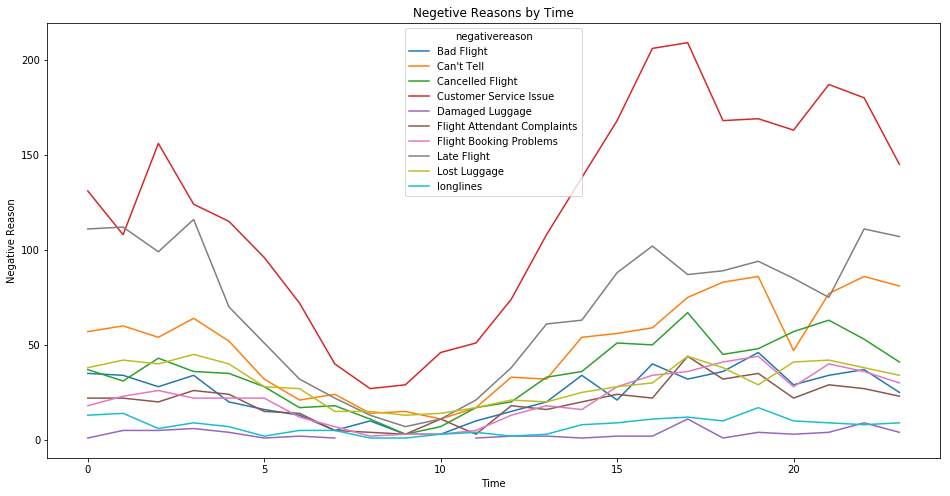

In [41]:
my_plot = pf_neg.unstack().plot(kind='line',figsize=(16, 8),rot=0,
                                title="Negetive Reasons by Time")
my_plot.set_xlabel("Time")
my_plot.set_ylabel("Negative Reason")

Text(0,0.5,u'Negative Reason')

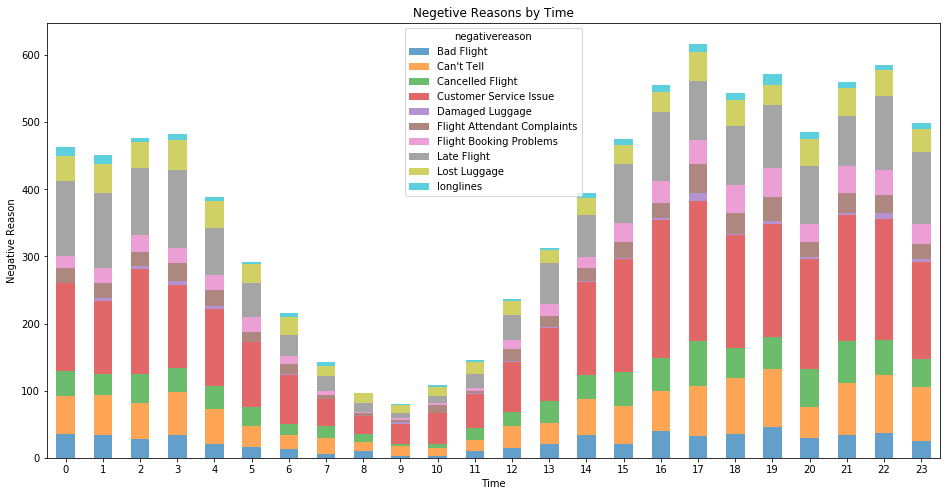

In [55]:
my_plot = pf_neg.unstack().plot(kind='bar',figsize=(16, 8),alpha=0.7,rot=0,stacked=True,
                                title="Negetive Reasons by Time")
my_plot.set_xlabel("Time")
my_plot.set_ylabel("Negative Reason")

In [43]:
percent3 = pf_neg.unstack().apply(lambda a: a / a.sum() * 100, axis=1)
percent3

negativereason,Bad Flight,Can't Tell,Cancelled Flight,Customer Service Issue,Damaged Luggage,Flight Attendant Complaints,Flight Booking Problems,Late Flight,Lost Luggage,longlines
tweet_created_hour,,,,,,,,,,
0,7.559395,12.311015,7.991361,28.293737,0.215983,4.751620,3.887689,23.974082,8.207343,2.807775
1,7.538803,13.303769,6.873614,23.946785,1.108647,4.878049,5.099778,24.833703,9.312639,3.104213
2,5.870021,11.320755,9.014675,32.704403,1.048218,4.192872,5.450734,20.754717,8.385744,1.257862
3,7.053942,13.278008,7.468880,25.726141,1.244813,5.394191,4.564315,24.066390,9.336100,1.867220
4,5.141388,13.367609,8.997429,29.562982,1.028278,6.169666,5.655527,17.994859,10.282776,1.799486
5,5.498282,10.996564,9.621993,32.989691,0.343643,5.154639,7.560137,17.525773,9.621993,0.687285
6,6.046512,9.767442,7.906977,33.488372,0.930233,6.511628,5.581395,14.883721,12.558140,2.325581
7,3.521127,16.901408,12.676056,28.169014,0.704225,3.521127,4.929577,15.492958,10.563380,3.521127
8,10.309278,14.432990,11.340206,27.835052,NaN,4.123711,2.061856,13.402062,15.463918,1.030928


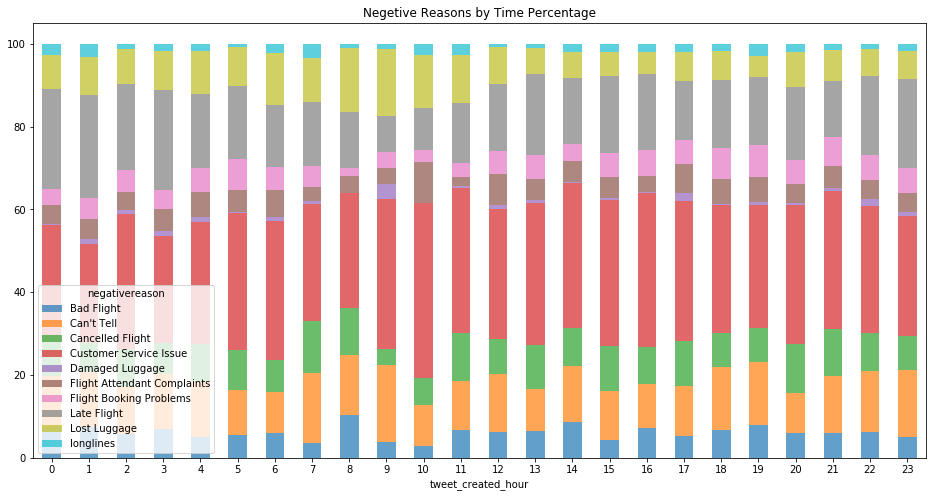

In [44]:
percent3.plot(kind='bar',figsize=(16, 8),alpha=0.7,rot=0,stacked=True,
             title="Negetive Reasons by Time Percentage")

### Word Embeddings

Word embeddings, or vector representations of words, are critical to building a CNN classifier. The vector representations of words are what will build up our input matrix. These vector space models represent words in a vector space such that similar words are mapped to nearby points. This representation rests on the Distributional Hypothesis, i.e. assumption that words that appear in similar contexts share semantic meaning. We will use gensim to train word embeddings from our corpus.

Word embeddings are dense vectors with a much lower dimensionality. Secondly, the semantic relationships between words are reflected in the distance and direction of the vectors.

**Word2Vec**

Another way of converting the words in the tweets to numerical values can be achieved with Word2Vec. Word2Vec maps each word in a multi-dimensional space. It does this by taking into account the context in which a word appears in the tweets. As a result, words that are semantically similar are also close to each other in the multi-dimensional space. 

The Word2Vec algorithm is implemented in the [gensim](https://radimrehurek.com/gensim/models/word2vec.html) package.

The Word2Vec algorithm uses lists of words as input. For that purpose we use the **word_tokenize** method of the the nltk package.

In [58]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 50   # Minimum word count      
num_workers = 4       # Number of threads to run in parallel
context = 7           # Context window size                                                           
downsampling = 1e-3   # Downsample setting for frequent words

In [59]:
def normalizer(text):
    tokens = word_tokenize(text)
    lower_case = [w.lower() for w in tokens]
    return lower_case

tweet["normalized_text"] = tweet.cleaned_text.apply(normalizer)

In [60]:
model = word2vec.Word2Vec(tweet.normalized_text, workers=num_workers,
                          size=num_features, min_count = min_word_count,
                          window = context, sample = downsampling)
model.init_sims(replace=True)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


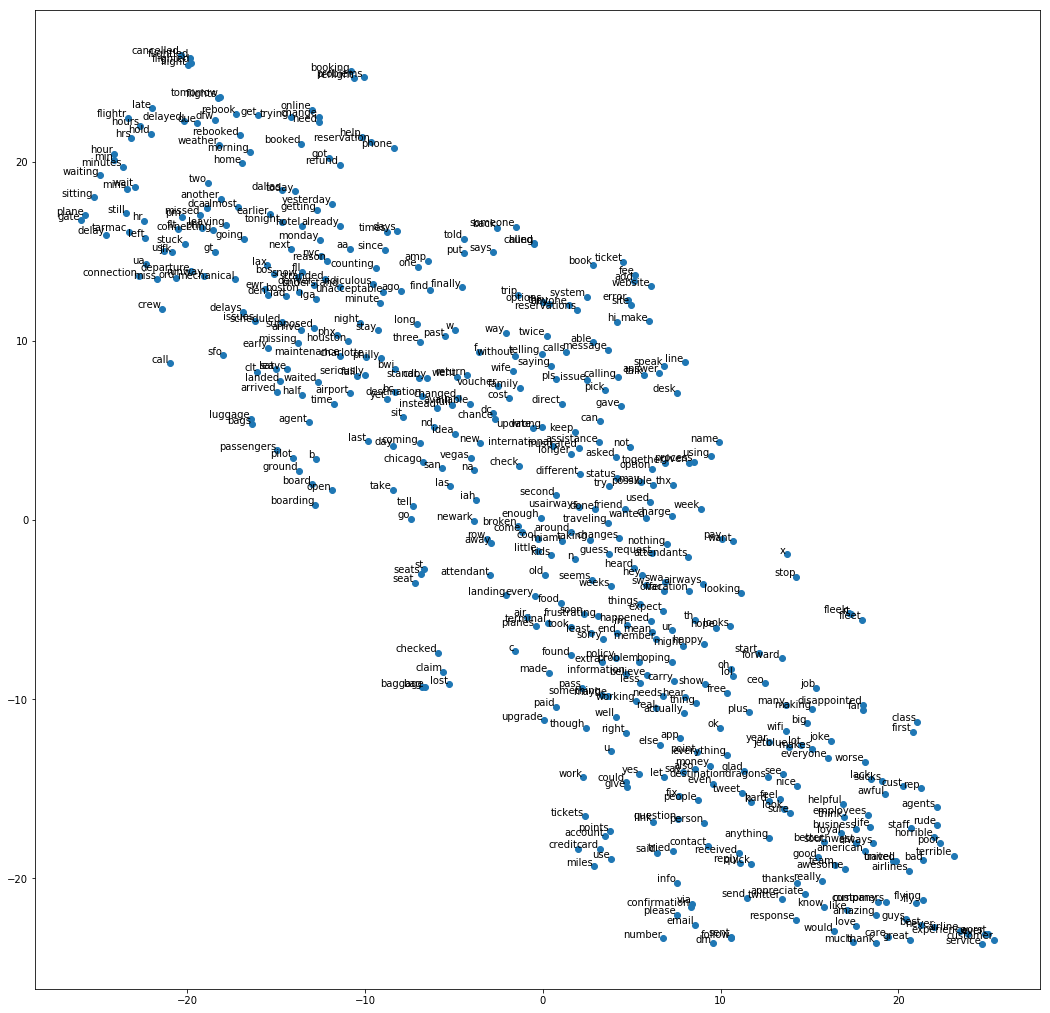

In [63]:
x = model[model.wv.vocab]
tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(x)
plt.rcParams["figure.figsize"] = (18,18)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])
labels = list(model.wv.vocab.keys())
for label, x, y in zip(labels, x_tsne[:, 0], x_tsne[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')
plt.show()